# Project Notebook: Optimizing Experimental Design



 This notebook was created by **Alicja Suchońska, Ewa Godlewska, Iheb Marouani, and Sabrina Namazova** as part of the block seminar *Optimizing Experimental Design*.  

In this notebook, we aimed to challenge **AutoRA (Automated Research Assistant)**—an open-source framework designed to automate multiple stages of the empirical research process, including **model discovery, experimental design, data collection, and open science documentation**.  

To test AutoRA, we implemented a **random sampler**, followed by **three theorists** provided by AutoRA. Finally, we conducted a **t-test** to determine whether the model-sampled data significantly differed from the randomly sampled data.  



# Notebook Structure  

1. **Task Definition** – Introduction to the problem and dataset.  
2. **Random Sampler Implementation** – Generating baseline data through random sampling.  
3. **AutoRA Theorist Implementations**  
   - Theorist 1: differentiable architecture search (DARTS)  
   - Theorist 2: Bayesian Machine Scientist (BMS)
   - Theorist 3:  Bayesian Symbolic Regression (BSR)
4. **Comparison and Statistical Analysis**  
   - Conducting a **t-test** to compare AutoRA-generated data with random samples.  
5. **Discussion and Conclusion** – Insights, limitations, and potential improvements.  

To start, we first need to download **AutoRA** and define our imports

In [1]:
from IPython.display import clear_output

In [2]:
!pip install "autora"
#added to clear output and make notebook "clear"
clear_output()

In [3]:
from typing import Callable, Iterable, Union, Optional,List
from numbers import Number
import itertools
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd

from autora.experiment_runner.synthetic.utilities import SyntheticExperimentCollection
from autora.variable import DV, IV, ValueType, VariableCollection


##**Task Definition** – Introduction to the problem and dataset

We will test AutoRA's theorists on the 2AFC task. In this task, participants are presented with a rectangle containing both orange and blue piles. The participant's goal is to decide whether there are more orange or blue piles. The task includes two independent parameters that can be adjusted: **scatteredness** and **ratio**.

To implement this task, we took the `twoafc()` function from the block seminar notebook, which defines a Two-Alternative Forced Choice (2AFC) experiment within the AutoRA framework (using `SyntheticExperimentCollection`). This function simulates an experiment where participants are presented with two stimuli and must make a choice. It structures the experiment, defines independent and dependent variables, sets constraints (`allowed_values` for each variable), and provides methods for running simulations (`run`), generating synthetic data, and visualizing results (with the `plotter` function).


In [4]:
def twoafc(
    parameters: np.ndarray,
    name="2AFC",
    resolution=100,
    minimum_value_condition: float = 0.,
    maximum_value_condition: float = 1.,
    design_per_participant: Optional[dict[int, tuple[float, float]]] = None,
):
    """
    2AFC experiment with two independent variables

    Args:
        parameters: abstract participant parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393
    """

    # Reshape parameters if it is a 1D array
    if len(parameters.shape) == 1:
        parameters = parameters.reshape(1, 2)

    # check that parameters are positive
    if any(parameters[:, 0] < 0):
        raise ValueError("The given parameters must be in the range [0, inf).")

    # Setting parameters for the experiment
    params = dict(
        name="2AFC",
        resolution=resolution,
        parameters=parameters,
        #design_per_participant=design_per_participant, # This part didn't work as expected, so it is commented out
    )
    #Set participant_id as independent variable
    participant_id = IV(
        name="participant_id",
        allowed_values=np.arange(
            0, len(parameters)
        ),
        value_range=(0, len(parameters)-1),
        units="",
        variable_label="participant_id",
        type=ValueType.REAL,
    )
    # Function to get specific value range for a participant if specified, otherwise use defaults
    def get_value_range(participant_idx, default_min, default_max):
        if design_per_participant and participant_idx in design_per_participant:
            return design_per_participant[participant_idx]
        return (default_min, default_max)

    # Loop through parameters to set range for ratio and scatteredness
    for i in range(len(parameters)):
        ratio_range = get_value_range(i, minimum_value_condition, maximum_value_condition)
        scatteredness_range = get_value_range(i, minimum_value_condition, maximum_value_condition)

    # Set ratio as independent variable
    ratio = IV(
        name="ratio",
        # allowed_values=np.linspace(
        #     minimum_value_condition, maximum_value_condition, resolution
        # ),
        value_range=ratio_range,
        units="",
        variable_label="ratio",
        type=ValueType.REAL,
    )

    # Define independent variable for scatteredness
    scatteredness = IV(
        name="scatteredness",
        # allowed_values=np.linspace(minimum_value_condition, maximum_value_condition, resolution),
        value_range=scatteredness_range,
        units="",
        variable_label="scatteredness",
        type=ValueType.REAL,
    )

    # Define dependent variable for response time(we will observe rt)
    response_time = DV(
        name="response_time",
        value_range=(0, 100),
        units="seconds",
        variable_label="response_time",
        type=ValueType.REAL,
    )

    # Create a collection of variables (independent and dependent)
    variables = VariableCollection(
        independent_variables=[participant_id, ratio, scatteredness],
        dependent_variables=[response_time],
    )

    # Set the unit ids for participants (based on parameters length)
    unit_ids = np.arange(len(parameters))

    # Define the function to run the experiment with conditions and noise
    def run(
        conditions: Union[pd.DataFrame, np.ndarray, np.recarray],
        added_noise: float = 0.01,
        random_state: Optional[int] = None,
    ):

        # Create random number generator for reproducibility
        rng = np.random.default_rng(random_state)
        X = np.array(conditions)
        Y = np.zeros((X.shape[0], len(variables.dependent_variables)))

        # Loop through conditions and compute the response time based on normal grand truth
        for idx, x in enumerate(X):
            y = (normal_ground_truth(x[1:], parameters[int(x[0])])).reshape(-1)
            if y == np.inf:
                print(f'smth wrong at index {idx}')
                print(f'conditions: {x}')
            Y[idx] = np.max(np.stack((np.zeros_like(y), y), axis=1), axis=1)

        # Store the experiment data in a DataFrame
        experiment_data = pd.DataFrame(conditions)
        experiment_data.columns = [v.name for v in variables.independent_variables]
        experiment_data[variables.dependent_variables[0].name] = Y
        return experiment_data

    ground_truth = partial(run, added_noise=0.0)

    # Define the domain (parameter space) for the experiment
    def domain():
        p_initial_values = variables.independent_variables[0].allowed_values
        trial_values = variables.independent_variables[1].allowed_values

        X = np.array(np.meshgrid(p_initial_values, trial_values)).T.reshape(-1, 2)
        return X

    def plotter(
        model=None
    ):
        import matplotlib.pyplot as plt
        from matplotlib import cm

        p_id = np.array([0])

        x_limit = variables.independent_variables[1].value_range
        y_limit = variables.independent_variables[2].value_range
        x_label = "Ratio"
        y_label = "Scatteredness"

        # define the factor levels
        x = ratio.allowed_values if ratio.allowed_values is not None else np.linspace(*variables.independent_variables[1].value_range)
        y = scatteredness.allowed_values if scatteredness.allowed_values is not None else np.linspace(*variables.independent_variables[2].value_range)
        x_mesh, y_mesh = np.meshgrid(x, y)
        p_id = np.full_like(x, p_id)
        sample_size = len(x)

        # collect the observations
        dvs = [dv.name for dv in variables.dependent_variables]

        # initiate the z array
        z_ground_truth = {dv: np.zeros((sample_size, sample_size)) for dv in dvs}
        #z_random = {dv: np.zeros((sample_size, sample_size)) for dv in dvs}
        if model is not None:
            z_model = {dv: np.zeros((sample_size, sample_size)) for dv in dvs}

        # Loop through the grid and simulate or sample data
        for i in range(sample_size):
            x = np.stack((p_id, x_mesh[i], y_mesh[i]), axis=-1)
            z = ground_truth(x)
             # use a model to predict values if model is defined
            if model is not None:
                z_m = model.predict(x)

            # Populate the result arrays with observed data
            for idx, dv in enumerate(dvs):
                z_ground_truth[dv][i, :] = z[dv]
                if model is not None:
                    z_model[dv][i, :] = z_m[idx]

        # make a surface plot to visualize the ground_truth
        for dv in dvs:
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
            ax.plot_surface(x_mesh, y_mesh, z_ground_truth[dv], cmap=cm.Blues, alpha=0.7)
            #ax.plot_surface(x_mesh, y_mesh, z_random[dv], cmap=cm.Greens, alpha=0.7) wasn't working like intended

            if model is not None:
                ax.plot_surface(x_mesh, y_mesh, z_model[dv], cmap=cm.Reds, alpha=0.7)

            ax.set_xlim(x_limit)
            ax.set_ylim(y_limit)
            ax.set_xlabel(x_label, fontsize="large")
            ax.set_ylabel(y_label, fontsize="large")
            ax.set_zlabel(dv, fontsize="large")
            ax.set_title("2AFC; DV: " + dv, fontsize="x-large")
            plt.show()


    # Create the SyntheticExperimentCollection
    collection = SyntheticExperimentCollection(
        name=name,
        description=twoafc.__doc__,
        variables=variables,
        run=run,
        ground_truth=ground_truth,
        domain=domain,
        plotter=plotter,
        params=params,
        factory_function=twoafc,
    )

    return collection

We added additional code from the resources folder to ensure we don't encounter issues with experimental units and other related components. This code defines a framework for simulating experiments with multiple experimental units, each performing a problem-solving task with noise. Key components include:

1. **`experimental_unit` class**:  
   Represents an experimental unit with a problem-solving function, noise function, and parameters. It includes methods to compute the dependent variable and add noise.

2. **`generate_dataset` function**:  
   Generates a dataset by collecting observations from multiple experimental units across various conditions, with optional repetitions and shuffling.

3. **Noise function**:  
   Generates random noise drawn from a normal distribution.

4. **Ground truth functions**:  
   These include models like linear, sigmoid, binomial, wave, and normal functions, which define the expected response (dependent variable) based on independent variables and parameters.


In [5]:
from typing import Callable, Iterable, Union, Optional
from numbers import Number
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd

from autora.experiment_runner.synthetic.utilities import SyntheticExperimentCollection
from autora.variable import DV, IV, ValueType, VariableCollection


class experimental_unit:

    def __init__(self,
        problem_solver: Callable,
        noise: Callable,
        parameters: Iterable,
        noise_level: float = 1,
        ):

        self.problem_solver_fun = problem_solver
        self.noise_fun = noise
        self.parameters = parameters
        self.noise_level = noise_level

    def problem_solver(self, conditions):
        # this method returns the dependent variable based on the independent variables x and y and the parameters
        return self.problem_solver_fun(conditions, self.parameters)

    def noise(self, noise_level=None):
        # this method returns the noise
        if noise_level == None:
            noise_level = self.noise_level

        return self.noise_fun(noise_level)

    def step(self, conditions, noise=True):
        # this method returns the observation which is the sum of the dependent variable and the noise
        if noise:
            obs =  self.problem_solver(conditions) + self.noise()
        else:
            obs = self.problem_solver(conditions)

        # make obs an array if obs is a scalar
        if not isinstance(obs, Iterable):
            obs = np.array(obs)

        if len(obs.shape) == 0:
            obs = obs.reshape(-1)

        return np.max(np.stack((np.zeros_like(obs), obs), axis=1), axis=1)


def generate_dataset(experimental_units: Iterable[experimental_unit], conditions: Iterable[Iterable[Number]], n_repetitions: int = 1, shuffle: bool = False):
    # check that each element of conditions has only two numeric sub-elements
    assert any([[isinstance(e, Number) for e in c] for c in conditions]), 'Some elements in the conditions argument appear to be not of length 2 or are non-numeric'

    n_experimental_units = len(experimental_units)
    n_conditions = len(conditions)

    # create an array which will be the dataset
    dataset = np.zeros((n_experimental_units, n_conditions, n_repetitions, 2+conditions.shape[-1]))

    for i in range(n_experimental_units):
        # here we collect the observations for each experimental unit
        for k in range(n_repetitions):
                # here we collect the observations for each repetition for each condition for each experimental unit
                # dataset[i, :, k] = experimental_units[i].step(conditions[:, 0], conditions[:, 1])
                observation = experimental_units[i].step(conditions)
                dataset[i, :, k, 0] += i
                dataset[i, :, k, 1:1+conditions.shape[-1]] = conditions
                dataset[i, :, k, -1] = observation

    if shuffle:
        np.random.shuffle(dataset)

    dataset_flat = dataset.reshape(-1, dataset.shape[-1])

    return dataset, dataset_flat

def noise(noise_level: float) -> float:
    """
    This function returns a random number drawn from a normal distribution with mean 0 and standard deviation noise_level

    Args:
        noise_level (float): the noise level

    Returns:
        float: a random number between
    """
    return np.random.normal(0, noise_level)


def linear_ground_truth(conditions, parameters: Union[list[float], float]=None) -> float:
    """
    This function returns the dependent variable based on the independent variables x and y and the parameters

    Args:
        x (float): the first independent variable
        y (float, Optional): the second independent variable
        parameter (list): the parameters for each independent variable; if y is None, then parameter must be a list of length 1; otherwise, parameter must be a list of length 2

    Returns:
        response (float): the response of the linear function
    """

    if isinstance(conditions, Iterable):
        assert len(conditions)<=2, "conditions must be an iterable of maximum length 2."
        if len(conditions) == 1:
            x = conditions[0]
        elif len(conditions) == 2:
            x, y = conditions[0], conditions[1]

        assert len(parameters)==len(conditions), "parameters must be an iterable of length 2."

    else:
        x, y = conditions, 0

    return parameters[0] * x + parameters[1] * y


def sigmoid_ground_truth(conditions, parameters: Union[float, list[float]]) -> float:
    """
    This function returns the dependent variable based on the independent variables x and y and the parameters

    Args:
        x (float): the independent variable
        parameter (list): the parameter for the independent variable; Parameter must be a list of length 1
        mirrored (bool, optional): If True, then the sigmoid function is mirrored horizontally. Defaults to True.

    Returns:
        response (float): the response of the sigmoid function
    """

    if isinstance(conditions, Iterable):
        if len(conditions.shape) == 1:
            assert len(conditions)==1, "conditions must be an iterable of length 1."
            x = conditions[0]
        elif len(conditions.shape) == 2:
            assert conditions.shape[-1]==1, "conditions must be an iterable of shape (n, 1)."
            x = conditions[:, 0]
    else:
        x = conditions
    assert len(parameters)==2, "parameters must be an iterable of length 2."

    return 1 / (1 + np.exp(parameters[1]*(-x + parameters[0])))


def binomial_ground_truth(conditions, parameters: list[float], response_time=False) -> float:
    """
    This function returns 1 or 0 based on the independent variable x and the parameters given to a sigmoidal function.

    Args:
        x (float): the independent variable
        parameter (list): the parameters for the sigmoidal function (0: bias, 1: sensitivity); Parameter must be a list of length 2

    Returns:
        response (float): the response of the working memory function
    """
    if isinstance(conditions, Iterable):
        assert len(conditions)==1, "conditions must be an iterable of length 1."
        x = conditions[0]
    else:
        x = conditions
    assert len(parameters)==2, "parameters must be an iterable of length 2."

    prob_wrong = sigmoid_ground_truth(x, parameters)
    response = np.random.choice((0, 1), p=np.array((prob_wrong, 1-prob_wrong)).reshape(-1,))

    if response_time:
        rt = np.random.lognormal(np.max((1, x-parameters[0])), 0.5)
        return response, rt
    else:
        return response


def wave_ground_truth(conditions, parameters: list[float, float, float, float, float]) -> float:
    """
    This function returns the dependent variable based on the independent variables x and y and the parameters

    Args:
        x (float): the first independent variable
        y (float): the second independent variable
        parameter (list): the parameters for each independent variable; Parameter must be a list of length 4

    Returns:
        response (float): the response of the multimodal function
    """

    assert len(conditions)==2, "conditions must be an iterable of length 2."
    assert len(parameters)==4, "parameters must be an iterable of length 4."

    x, y = conditions[0], conditions[1]

    assert isinstance(parameters, list) and len(parameters) == 4, 'parameters must be a list of length 4'
    wave = parameters[0]*np.sin(parameters[0] * x) + np.cos(parameters[1] * y)
    parabola = parameters[2]*x**2 + parameters[3]*y**2
    return wave + parabola


def normal_ground_truth(conditions, parameters=np.ones(2,)):
    """This ground truth takes in two factors and a set of parameters and returns a response

    Args:
        x (float): The level of the first factor
        y (float): the level of the second factor
        parameters (Iterable[float], optional): The parameters give an individual configuration for each experimental unit. Defaults to np.ones(2,).

    Returns:
        float: Dependent variable which serves as the response
    """

    # this is an example of a ground truth function with two linear terms and a constant term
    # dependent_variable = parameters[0] * x + parameters[1] * y + parameters[0] - parameters[1]
    assert conditions.shape[-1]==2, "conditions must be an iterable of length 2."
    assert parameters.shape[-1]==2, "parameters must be an iterable of length 2."

    if len(conditions.shape) == 1:
        x, y = conditions[0], conditions[1]
    else:
        x, y = conditions[:, 0], conditions[:, 1]

    # this is an example of a bell-shaped function which can saturate
    dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])

    return dependent_variable

## Random Sampler Implementation – Generating baseline data through random sampling


For testing model performance, we need a function that generates combinations of **ratio** and **scatteredness**. To achieve this, we wrote the `random_sampler_iv` function, which takes the following parameters:  

- `variable_collection`: A collection of available variables.  
- `num_samples`: The number of samples to generate.  
- `num_participants`: The number of participants in the experiment.  
- `random_state`: A seed for reproducibility.  
- `sample_all`: A flag that determines whether to sample from a provided dataset or generate new samples.  

The function extracts available independent variables (in our case, **ratio** and **scatteredness**) from the `variable_collection` and randomly generates combinations of these variables.  

This function is primarily based on the **random sampler** from the original **block course notebook**. We modified the function by adding parameters such as `num_participants`. If `sample_all` is provided, sampling is done based on the specified condition for `sample_all`. For example, if `sample_all = participant_id`, each participant in the experiment will receive the same conditions.  

However, in some cases, it is necessary to have a different experimental setup for each participant. To accommodate this, the user can specify the number of participants, and the function will assign **fixed participant IDs** while randomly generating values for the independent variables (**ratio** and **scatteredness**).  


In [6]:
def random_sampler_for_iv(
    variables: VariableCollection,
    num_samples: int = 5,
    num_participants: int = 1,
    random_state: Optional[int] = None,
    replace: bool = True,
    sample_all: Optional[List[str]] = None,
):
    """
    Generates a dataset by randomly sampling independent variables (IVs) from a given VariableCollection.

    Parameters:
    - variables (VariableCollection): A collection of independent variables.
    - num_samples (int): Number of samples per participant.
    - num_participants (int): Number of participants in the experiment.
    - random_state (Optional[int]): Seed for random number generation (for reproducibility).
    - replace (bool): Whether to allow sampling with replacement.
    - sample_all (Optional[List[str]]): List of IVs that should not be randomly sampled
      but instead use all available values.

    Returns:
    - final_df (pd.DataFrame): A DataFrame containing the sampled conditions.
    """

    rng = np.random.default_rng(random_state)
    # Dictionary to store sampled conditions for each independent variable
    raw_conditions = {}

    participant_column = None # For storing the name of the participant column if it exists

    # Iterate through the independent variables in the variable collection
    for iv in variables.independent_variables:
      # Identify participant column and ensure each participant ID remains fixed across conditions
        if iv.name.lower() in ["participant", "participant_id"]:
            participant_column = iv.name  # Identify the participant ID column
            raw_conditions[iv.name] = np.repeat(iv.allowed_values, num_samples)  # Keep participant ID fixed


        elif iv.allowed_values is not None:
            if sample_all and iv.name in sample_all:
              # If `sample_all` is specified for this IV, use all allowed values
                raw_conditions[iv.name] = iv.allowed_values
                # Otherwise, randomly sample values for this IV
            else:
                raw_conditions[iv.name] = rng.choice(
                    iv.allowed_values, size=num_samples * num_participants, replace=replace
                )
         # If IV has a defined range and is of type REAL, sample from a uniform distribution
        elif (iv.value_range is not None) and (iv.type == ValueType.REAL):
            raw_conditions[iv.name] = rng.uniform(*iv.value_range, size=num_samples * num_participants)
        else:
            raise ValueError(
                "allowed_values or [value_range and type==REAL] needs to be set for %s" % (iv)
            )

    if sample_all:
        """
        If `sample_all` is provided, generate all possible combinations of the specified IVs
        and combine them with randomly sampled values for other IVs.
        """

        # Handle variables specified in `sample_all`
        all_conditions = [raw_conditions.pop(iv_name) for iv_name in sample_all]
        sample_all_combinations = list(itertools.product(*all_conditions))

        # Combine with randomly sampled variables
        other_conditions = pd.DataFrame(raw_conditions)

        # Create the final dataframe
        final_rows = []
        for sample in sample_all_combinations:
            for _, row in other_conditions.iterrows():
                final_rows.append((*sample, *row.values))

        final_columns = sample_all + list(raw_conditions.keys())
        final_df = pd.DataFrame(final_rows, columns=final_columns)
    else:
        """
        If `sample_all` is not provided, generate unique conditions for each participant
        while keeping their participant ID fixed.
        """
        condition_rows = []
        for i in range(num_participants):
            start_idx = i * num_samples
            end_idx = start_idx + num_samples
            # Extract conditions for the current participant
            participant_conditions = {key: values[start_idx:end_idx] for key, values in raw_conditions.items()}
            df = pd.DataFrame(participant_conditions)
            condition_rows.append(df)

        # Combine data for all participants
        final_df = pd.concat(condition_rows, ignore_index=True)

    return final_df


To test the `random_sampler_for_iv` function, we first need to define the experiment, which requires specifying its key parameters, including ratio and scatteredness.

In [7]:
# Basic experiment parameters
n_units = 100  # Number of experimental units (here trials)
noise_level = 0.  # Noise level in the experiment (set to zero for now)

# Generate parameters for each experimental unit
parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 0, parameters)  # Ensure all parameters are non-negative

Next, we set up the **experiment** itself and define **the experimentalist**, who is responsible for designing follow-up experiments by selecting appropriate conditions for data collection.

**The experimentalist** will use the `random_sampler_for_iv`` function, which we previously defined, to sample *independent variable (IV)* combinations and determine the experimental conditions.

In [8]:
# define experiment
experiment = twoafc(parameters)

# define experimentalist
experimentalist = random_sampler_for_iv

In [9]:
experimentalist

<function __main__.random_sampler_for_iv(variables: autora.variable.VariableCollection, num_samples: int = 5, num_participants: int = 1, random_state: Optional[int] = None, replace: bool = True, sample_all: Optional[List[str]] = None)>

##  **AutoRA Theorist Implementations**

After defining the **experimentalist**, we can set up the available **theorists**. Theorists are responsible for identifying patterns in the data and developing models to explain human information processing.  

In our setup, we use several modeling approaches, including:  

1. **FFN Regressor**  
   - A feedforward neural network (FFN) regressor, originally used in the **block course notebook**.  
   
2. **Differentiable Architecture Search (DARTS)**  
   - DARTS is a neural architecture search method that **relaxes the search space** to be continuous, allowing architecture search to be performed via **gradient descent**.  
   - It has been successfully used to discover effective network architectures for **image classification** and **language modeling**, often matching the performance of architectures designed by human researchers.  
   - **AutoRA** provides an adaptation of DARTS to automate the discovery of interpretable **quantitative models** that explain **human information processing** (Musslick, 2021).  

3. **Bayesian Machine Scientist (BMS)**  
   - BMS combines:  
     1. **A Bayesian approach**, which specifies informed priors over symbolic expressions and computes their posterior probabilities based on the data.  
     2. **A Markov Chain Monte Carlo (MCMC) algorithm**, which samples from the posterior distribution to efficiently explore the space of possible symbolic expressions.  
   - **AutoRA** provides an adapted version of BMS to automate the discovery of **interpretable models** of **human information processing**.  

4. **Bayesian Symbolic Regression (BSR)**  
   - Symbolic regression refers to a class of algorithms that search for **interpretable symbolic expressions** to capture relationships within data.  
   - Instead of relying on predefined model structures, SR attempts to find compositions of simple functions that accurately map **independent variables** to **dependent variables**.  
   - BSR is a **specific SR method** proposed by Jin et al. (2019) that **leverages a Bayesian framework** to search for concise and interpretable symbolic expressions.  
   - **AutoRA** provides an adapted version of BSR for automating the discovery of **interpretable models** of **human information processing**.


In [10]:
# Install theorists for automated model discovery
!pip install -q "autora[theorist-bms]"  # Bayesian Machine Scientist (BMS)
!pip install "autora[theorist-darts]"   # Differentiable Architecture Search (DARTS)
!pip install "autora[theorist-bsr]"     # Bayesian Symbolic Regression (BSR)
clear_output()

We define the `FFNRegressor` class manually, as it was originally located in the `resources` folder. This class is a scikit-learn compatible regressor that uses a feedforward neural network (FFN) for regression tasks. Below is a brief description of the code:

**FFN Class**
- A simple feedforward neural network designed for regression tasks. It can handle both categorical (unit IDs) and continuous (condition values) inputs.
- **Usage**: The `forward` method processes input data, concatenates embeddings (if applicable), and passes the data through the network to produce predictions.

**FFNRegressor Class**
- A wrapper for the FFN model that integrates with scikit-learn's `BaseEstimator` for compatibility with scikit-learn workflows..
- **Usage**:
  - Use `fit` to train the model on input data `X` and target values `y`.
  - Use `predict` to generate predictions for new input data.



In [11]:
import numpy as np
import torch
from torch import nn

from sklearn.base import BaseEstimator
# Define a feedforward neural network (FFN)
class FFN(nn.Module):
    def __init__(self, n_units: int, n_conditions: int, embedding_size: int = 8, hidden_size: int = 16, dropout = 0., activation=nn.Identity):
        super(FFN, self).__init__()
        # Store parameters
        self.n_units = n_units
        self.n_conditions = n_conditions
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.dropout = dropout

        # Embedding layer for units
        self.unit_embedding = nn.Embedding(n_units, embedding_size) if n_units > 0 else None

        # Linear layer to process the concatenated input
        self.linear_in = nn.Linear(embedding_size + n_conditions, hidden_size)
        self.activation = nn.ReLU()
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)
        # Output layer (single neuron predicting continuous values)
        self.linear_out = nn.Linear(hidden_size, 1)
        self.activation_out = activation()

    def forward(self, X):
        """
        Forward pass of the network.
        X: Input tensor (first column: unit ID, rest: condition values)
        """

        if self.unit_embedding is not None:
          # Split the input into unit ID and condition values
            unit_id, condition = X[:, 0][:, None], X[:, 1:]

            # check data types of tensors
            unit_id = unit_id.int()

            # Obtain embedding for the given unit IDs
            unit_embedding = self.unit_embedding(unit_id)

            # Concatenate unit embedding and conditions along the last dimension
            concatenated_input = torch.cat((unit_embedding, condition.unsqueeze(1)), dim=-1)  # Corrected usage
        else:
            # if no unit embedding in network -> pass in X only the necessary conditions; Not the unit_id
            concatenated_input = X

        # Pass the concatenated input through the linear layer
        hidden = self.activation(self.linear_in(concatenated_input))
        hidden = self.dropout(hidden)
        out = self.activation_out(self.linear_out(hidden))
        return out.squeeze(1)

# Define a regression model using FFN and sklearn's BaseEstimator
class FFNRegressor(BaseEstimator):

    def __init__(
        self,
        module: nn.Module, # The neural network module (FFN)
        criterion = nn.MSELoss,
        optimizer = torch.optim.Adam,
        max_epochs: int = 10,
        batch_size: int = 1024,
        lr: float = 0.01, # Learning rate
        device = torch.device('cpu'),
        verbose=True, # Whether to print training progress
        ):

        super(FFNRegressor, self).__init__()
        self.device = device

        self.module = module.to(self.device)  # Move model to specified device (CPU/GPU)
        self.criterion = criterion()
        self.optimizer = optimizer(self.module.parameters(), lr=lr)
        self.lr = lr
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.dataloader = torch.utils.data.DataLoader
        self.dataset = torch.utils.data.Dataset

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Train the model using provided input data X and target values y.
        """
        X = torch.tensor(X.values.astype(np.float32) if hasattr(X, 'values') else X, dtype=torch.float32, device=self.device)
        y = torch.tensor(y.values.astype(np.float32) if hasattr(y, 'values') else y, dtype=torch.float32, device=self.device)

        if self.verbose:
            print('\nepoch\ttrain loss')

        # Set the model to training mode
        self.module.train()
        for epoch in range(self.max_epochs):
            epoch_loss = 0
            idx_shuffled = torch.randperm(X.shape[0])
            X, y = X[idx_shuffled], y[idx_shuffled]
            n_batch_repetitions = 0

            for i in range(0, len(X), self.batch_size):
                X_batch, y_batch = X[i:i+self.batch_size], y[i:i+self.batch_size]

                prediction = self.module(X_batch)

                loss = self.criterion(prediction, y_batch)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                n_batch_repetitions += 1

            if self.verbose:
                print(f"{epoch + 1}/{self.max_epochs}\t{epoch_loss/n_batch_repetitions:.8f}")
        self.module.eval()

    def predict(self, X: np.ndarray):
        """
        Predict the target values for the given input data X.
        """
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        return self.module(X).detach().cpu().numpy()

    def set_device(self, device: torch.device):
        """
        Set the device for the model.
        """
        self.device = device
        self.module = self.module.to(device)


After, we import and define various theorists from the `autora` library. Below is a brief explanation of the theorists and their configurations:

1. **FFNRegressor**:
   - *A custom feedforward neural network (FFN) regressor implemented manually above.
   - **Configuration**:
     - `FFN(n_units, 2)`: The FFN model is initialized with `n_units` (number of units) and 2 condition variables.
     - `max_epochs=10`: The model is trained for 10 epochs.
     - `lr=0.1`: The learning rate is set to 0.1.

2. **BMSRegressor**:
   - A Bayesian Model Selection (BMS) regressor.
   - **Configuration**:
     - `epochs=10`: The model is trained for 10 epochs (default is 1500, but reduced here for demonstration purposes).

3. **BSRRegressor**:
   -  A Bayesian Symbolic Regression (BSR) regressor.
      - **Configuration**:
     - `itr_num=500`: This is the number of optimization steps the algorithm will take to search for the best model

4. **DARTSRegressor**:
   -  A Differentiable Architecture Search (DARTS) regressor.
   - **Configuration**:
     - `num_graph_nodes=5`: Number of latent variables in the model.
     - `max_epochs=50`: Maximum number of training epochs.
     - `arch_learning_rate_max=0.01`: Initial learning rate for architecture updates.
     - `arch_weight_decay=0.0005`: Weight decay for architecture weights.
     - `arch_weight_decay_df=0.0001`: Additional weight decay based on parameters.
     - `param_updates_per_epoch=100`: Number of parameter updates per epoch.
     - `param_learning_rate_max=0.01`: Initial learning rate for parameter updates.
     - `param_learning_rate_min=0.001`: Minimum learning rate for parameter updates.

In [12]:
# Importing the needed theorists from Autora
from autora.theorist.bms import BMSRegressor
from autora.theorist.bsr import BSRRegressor
from autora.theorist.darts import DARTSRegressor
# define theorists
FFN_theorist = FFNRegressor(FFN(n_units, 2), max_epochs=10, lr=0.1)
# Added BMS, need to write how many epochs, normally 1500 (defoult causes issues, need to indicate)
bms_theorist = BMSRegressor(epochs=10)
bsr_theorist = BSRRegressor(itr_num=500)
darts_theorist = DARTSRegressor(
    num_graph_nodes=5,             # Number of latent variables
    max_epochs=50,                 # Maximum number of epochs
    arch_learning_rate_max=0.01,   # Initial learning rate for architecture updates
    arch_weight_decay=0.0005,      # Weight decay for architecture weights
    arch_weight_decay_df=0.0001,   # Additional weight decay based on parameters
    param_updates_per_epoch=100,   # Number of parameter updates per epoch
    param_learning_rate_max=0.01,  # Initial learning rate for parameter updates
    param_learning_rate_min=0.001  # Minimum learning rate for parameter updates
)

After importing the necessary models, we initialize the `StandardState` object, which serves as a centralized container for managing variables, conditions, experimental data, and models. Here's a step-by-step explanation of the process:

- We extract the names of the independent variables (`iv_names`) and dependent variables (`dv_names`) from the `experiment.variables` object.
- Using the `random_sampler_for_iv` function, we generate random conditions for the independent variables.
- The argument `sample_all=['participant_id']` ensures that participant IDs are included in the sampling process(all participants "see" the same conditions)
- A random seed (`random.seed(42)`) is set for reproducibility.

**Initializing the `StandardState`**

We create an instance of `StandardState` with the following components:

- **`variables`**: The independent and dependent variables defined in `experiment.variables`.
- **`conditions`**: The randomly generated conditions for the independent variables.
- **`experiment_data`**: An empty DataFrame with columns for both independent and dependent variables. This will store the experimental data as it is collected.
- **`models`**: A list of the initialized models (theorists) that will be used for modeling and analysis. The models are:

  1. `FFN_theorist` (index `0`): Feedforward Neural Network.
  2. `bms_theorist` (index `1`): Bayesian Model Selection.
  3. `darts_theorist` (index `2`): Differentiable Architecture Search.

P.S. We tried to configure the `BSR_theorist` within the StandardState, but it was throwing errors during fitting, so we decided to fit it manually.

The models can be accessed using indexing on the `models` list. For example:

```python
models[0]  # Refers to the FFN_theorist
models[1]  # Refers to the bms_theorist
models[2]  # Refers to the darts_theorist


In [13]:
from autora.state import StandardState, on_state, estimator_on_state
import random
random.seed(42)
# define variable names
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]

# define seed condition data
conditions = random_sampler_for_iv(experiment.variables, sample_all=['participant_id'])

# initialize state
s = StandardState(
    variables = experiment.variables,
    conditions = conditions,
    experiment_data = pd.DataFrame(columns=iv_names+dv_names),
    models=[FFN_theorist, bms_theorist, darts_theorist],
)

To check how conditions were generated

In [14]:
conditions.head()

,participant_id,ratio,scatteredness
0,0,0.128699,0.252731
1,0,0.075032,0.807839
2,0,0.005200,0.988544
3,0,0.849441,0.122668
4,0,0.201610,0.822103


Applying the logic of `random_sampler_iv`, we design `random_sampler_dv`, which acts as **a random model** by generating dependent variables. In our case, it simulates reaction times.

The function `random_sampler_dv` randomly assigns values to dependent variables based on predefined distributions( normal distribution with μ=1.5 and σ =0.2)

In [15]:
from typing import Optional, List

#sampler for random sampling dv(in our case reaction time)
def random_sampler_dv(variables: VariableCollection,
                      conditions: pd.DataFrame,
                      random_state: Optional[int] = None,
                      replace: bool = True,
                      sample_all: Optional[List[str]] = None) -> pd.DataFrame:
    rng = np.random.default_rng(random_state)

    # Create a copy of the conditions DataFrame to avoid modifying the original
    final_df = conditions.copy()

    # Sample dependent variables and add them as new columns
    for dv in variables.dependent_variables:
        mean = 1.5  # Mean reaction time
        std_dev = 0.2  # Standard deviation (adjust as needed)
        sampled_values = rng.normal(mean, std_dev, size=len(conditions))
        #print(f"Sampled reaction times: {sampled_values}")  # Debugging print
        final_df[dv.name] = sampled_values
        if dv.allowed_values is not None:
            sampled_values = rng.choice(dv.allowed_values, size=len(conditions), replace=replace)
            #print(f"Sampled {dv.name}: {sampled_values}")  # Debugging print
            final_df[dv.name] = sampled_values
        elif dv.value_range is not None and dv.type == ValueType.REAL:
            sampled_values = rng.uniform(*dv.value_range, size=len(conditions))
            #print(f"Sampled {dv.name}: {sampled_values}")  # Debugging print
            final_df[dv.name] = sampled_values
        else:
            raise ValueError(
                "allowed_values or [value_range and type==REAL] needs to be set for %s" % (dv)
            )

    return final_df

AutoRA provides an `on_state` function that transforms a target function into a function operating on a `State` object with **kwargs. We use this functionality to define a set of functions that run the experiment on the initialized `StandardState`.  
1. **`experiment_s`** – Executes the experiment on the given state and returns experimental data as output.  
2. **`experimentalist_s`** – Runs the **random sampler for independent variables**, effectively generating the **experimental design** by defining conditions.  
3. **Executing Theorists on States** – Once the experiment is set up, we run different theorists on the state

In [16]:
# wrap the loop components to make them operate on the state
experiment_s = on_state(experiment.run, output=['experiment_data'])
experimentalist_s = on_state(random_sampler_for_iv, output=['conditions'])
random_s = on_state(random_sampler_dv, output=['experiment_data'])
FFN_theorist_s = estimator_on_state(FFN_theorist)
bms_theorist_s = estimator_on_state(bms_theorist)
darts_theorist_s = estimator_on_state(darts_theorist)

Here, we will transform the data to fit it into the BSR Regressor manually.

In [43]:
# Extracting conditions from standard state
X = np.array([
    [float(row["ratio"]), float(row["scatteredness"])]
    for index, row in s.conditions.iterrows()
], dtype=np.float64)
#generating "ground_truth" reaction times
y = np.array(normal_ground_truth(X), dtype=np.float64)


In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#transforming conditions into applicable format
X = scaler.fit_transform(X)
#fitting data into BRS
bsr_theorist.fit(X, y)
#predicting data
y_pred = bsr_theorist.predict(X)

In [45]:
len(X)

10000

In [46]:
len(y_pred)

10000

## **Comparison and Statistical Analysis**  

Now that we have set up the experimental design and generated experimental data, we can **train our theorists**. This is done through an experimentation loop, where:  

1. **We generate conditions** using `experimentalist_s` (100 participants, 100 samples, fixed random seed for reproducibility).  
2. **We generate random data** using `random_s`.  
3. **We execute the experiment** using `experiment_s` (with optional noise control).  
4. **Each theorist is trained** on the experimental state:  
   - `FFN_theorist_s` (Feedforward Neural Network)  
   - `bms_theorist_s` (Bayesian Model Selection)  
   - `darts_theorist_s` (Differentiable Architecture Search)  
   - *`bsr_theorist_s` for Bayesian Symbolic Regression, currently commented out*  

After, we plot the models trained by each theorist to analyze their performance:  

```python
experiment.plotter(s.models[0])  # FFN Theorist
experiment.plotter(s.models[1])  # BMS Theorist
experiment.plotter(s.models[2])  # DARTS Theorist


In [21]:
# start the experimentation loop
for cycle in range(1):
  s = experimentalist_s(s, num_samples=100, random_state=42+cycle,num_participants=100)
  random_data=random_s(s,random_state=42+cycle)
  s = experiment_s(s, added_noise=0.0, random_state=42+cycle)
  s = FFN_theorist_s(s)
  s = bms_theorist_s(s)
  s = darts_theorist_s(s)


epoch	train loss
1/10	0.21458018
2/10	0.05231196
3/10	0.01627781
4/10	0.01146214
5/10	0.00933650
6/10	0.00808331
7/10	0.00758853
8/10	0.00708738
9/10	0.00724273
10/10	0.00708050


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

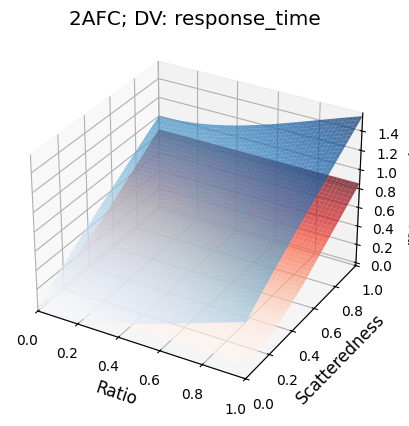

In [22]:
experiment.plotter(s.models[0])

The FFN Regressor demonstrates varying performance across different regions of the input space, as visualized in the surface plot.
- The model performs well in regions where the **ratio is moderate (~0.5)** and **scatteredness is around ~0.6**.In these regions, the predicted (red) and ground truth (blue) surfaces show **strong overlap**, resulting in a **purple hue**. This indicates that the model’s predictions align closely with the ground truth.
- At higher reaction times, particularly where the ground truth reaches its maximum value of **1.4**, the model consistently **underestimates** the response.The ground truth surface shows **dark blue regions** (indicating high reaction times), while the predicted surface remains **lighter red** (indicating lower predictions). The model’s predictions are capped at **~1.0**, significantly below the ground truth maximum.
This underestimation suggests a **bias in the model** towards lower reaction times, potentially due to regularization, insufficient representation of high reaction times in the training data, or an inherent limitation in the model’s capacity.

- The model’s performance degrades at **higher ratio values (~0.6+)**.
In these regions, the ground truth surface **darkens** (indicating higher reaction times), but the predicted surface remains **lighter red**, showing a clear discrepancy.The model struggles to generalize to higher ratio values, possibly because these regions are underrepresented in the training data or because the relationship between ratio and reaction time becomes more complex.

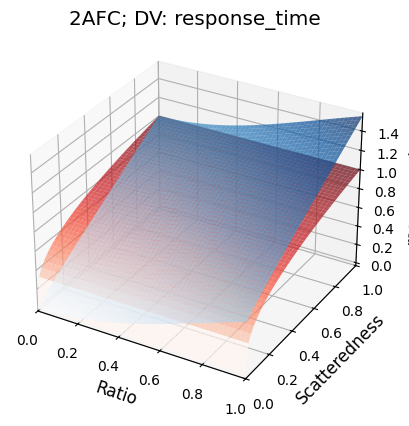

In [23]:
experiment.plotter(s.models[1])

The BMS regressor follows the general trend of the ground truth (blue surface) well, as seen by the significant overlap (slightly purple regions).
The model performs well when the **ratio and scateredness is moderate (\~0.6)** a (\~1), where the predicted (red) and ground truth (blue) surfaces align closely, forming a purple hue.
However, at higher reaction times (\~1.4), the model systematically underestimates responses, capping its predictions at around 1.0. This suggests either a limitation in model capacity or an issue in the training data distribution.

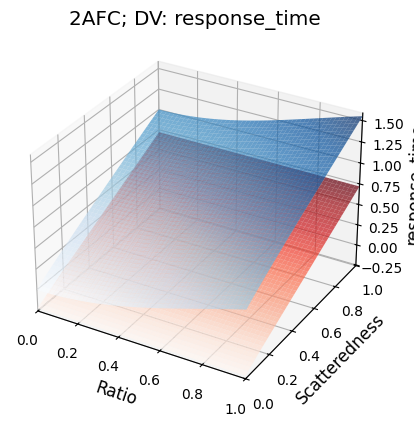

In [24]:
experiment.plotter(s.models[2])

The DARTS regressor struggles to follow the general trend of the ground truth , as indicated by the lack of strong overlap. The model consistently underestimates response times, with the predicted surfac sitting below the ground truth across most of the input space. Unlike BMS, which aligned well in certain regions, DARTS fails to capture the correct relationship between ratio and scatteredness.

While some alignment occurs at low scatteredness (0.2-0.4), the model significantly under-predicts reaction times at higher scatteredness values. 

This suggests a fundamental mismatch between the learned function and the true data distribution, possibly due to overfitting

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def plot_3d_reaction_time(X, y, y_pred, random_data):
    """
    Plots a 3D surface comparing ground truth and predicted reaction times.

    Parameters:
    X : numpy array
        Input features with standardized ratio and scatteredness.
    y : numpy array or tuple
        Ground truth reaction times.
    y_pred : numpy array
        Predicted reaction times.
    random_data : object
        Contains independent variable ranges for creating a grid.
    """
    # Extract original conditions
    ratio = X[:, 0]  # Standardized ratio
    scatteredness = X[:, 1]  # Standardized scatteredness

    # Ensure y is properly shaped
    if isinstance(y, tuple):
        y = y[0]
    reaction_time_true = y.flatten()
    reaction_time_pred = y_pred.flatten()

    # Create a structured grid
    grid_x, grid_y = np.meshgrid(
        np.linspace(*random_data.variables.independent_variables[1].value_range),
        np.linspace(*random_data.variables.independent_variables[2].value_range)
    )

    # Interpolate both ground truth and predicted reaction times
    grid_z_true = griddata((ratio, scatteredness), reaction_time_true, (grid_x, grid_y), method='cubic')
    grid_z_pred = griddata((ratio, scatteredness), reaction_time_pred, (grid_x, grid_y), method='cubic')

    # Create 3D figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot for ground truth (Blue)
    surf_true = ax.plot_surface(grid_x, grid_y, grid_z_true, cmap='Blues', alpha=0.6, edgecolor='none')

    # Surface plot for predicted values (Red)
    surf_pred = ax.plot_surface(grid_x, grid_y, grid_z_pred, cmap='Reds', alpha=0.6, edgecolor='none')

    # Labels and title
    ax.set_xlabel("Ratio (Standardized)")
    ax.set_ylabel("Scatteredness (Standardized)")
    ax.set_zlabel("Reaction Time")
    ax.set_title("3D Surface Plot: Ground Truth vs Predicted Reaction Time for BRS")

    # Add color bars for reference
    fig.colorbar(surf_true, ax=ax, shrink=0.5, aspect=5, label="Ground Truth RT")
    fig.colorbar(surf_pred, ax=ax, shrink=0.5, aspect=5, label="Predicted RT")

    plt.show()

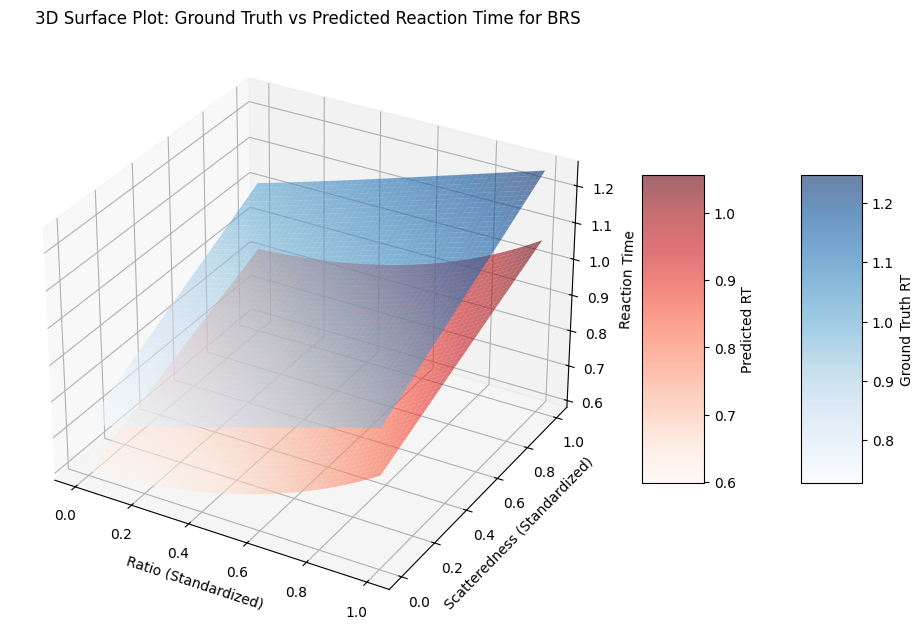

In [48]:
plot_3d_reaction_time(X, y, y_pred, random_data)

The BSR regressor follows roughly the general trend of the ground truth well, as seen by some overlap. The model performs well when the ratio is low to moderate (~0.2-0.6) and scatteredness is below ~0.8, where the predicted and ground truth surfaces align more closely.

However, at higher scatteredness values (1.0), the model consistently underestimates reaction times. The predicted surface remains below the ground truth surface , failing to capture the full range of reaction times. Unlike BMS and FFN, which capped their predictions at 1.0, BSR never reaches the maximum ground truth values (1.2), suggesting a limitation in capturing extreme responses.

Additionally, the model’s underestimation seems to persist across the entire input space, rather than just at high scatteredness values. This indicates that BSR might be biased toward lower reaction times.








In [27]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

def compare_theorist_vs_random(theorist_data, random_data):
    """
    Compares response times from the theorist model vs. random sampling.

    Args:
        theorist_data (pd.DataFrame): Experiment results from the theorist model.
        random_data (pd.DataFrame): Experiment results from random sampling.

    Returns:
        None (prints statistical results)
    """

    dv_name = "response_time"  # Adjust this if your dependent variable has a different name

    # Extract dependent variable values
    theorist_rt = theorist_data[dv_name].values
    random_rt = random_data[dv_name].values

    # Compute descriptive statistics
    mean_theorist, std_theorist = np.mean(theorist_rt), np.std(theorist_rt)
    mean_random, std_random = np.mean(random_rt), np.std(random_rt)

    # Run an independent t-test (assuming different distributions)
    t_stat, p_value = ttest_ind(theorist_rt, random_rt, equal_var=False)  # Welch’s t-test

    # Compute effect size (Cohen’s d)
    pooled_std = np.sqrt((std_theorist**2 + std_random**2) / 2)
    cohen_d = (mean_theorist - mean_random) / pooled_std

    # Print results
    print("### Comparison of Theorist vs. Random Sampling ###")
    print(f"Theorist Model: Mean={mean_theorist:.3f}, Std={std_theorist:.3f}")
    print(f"Random Sampling: Mean={mean_random:.3f}, Std={std_random:.3f}")
    print(f"T-Test: t={t_stat:.3f}, p={p_value:.5f}")
    print(f"Effect Size (Cohen’s d): {cohen_d:.3f}")

    # Interpretation
    if p_value < 0.05:
        print("Statistically significant difference (p < 0.05).")
    else:
        print("No significant difference found.")


In [28]:
compare_theorist_vs_random(s.experiment_data,random_data.experiment_data)

### Comparison of Theorist vs. Random Sampling ###
Theorist Model: Mean=0.829, Std=0.406
Random Sampling: Mean=50.361, Std=28.883
T-Test: t=-171.464, p=0.00000
Effect Size (Cohen’s d): -2.425
Statistically significant difference (p < 0.05).


The Theorist Model performs vastly differently from Random Sampling.
The difference is highly statistically significant (p ≈ 0).
The effect size is enormous, meaning the difference is not just statistically significant but also practically meaningful.
Since the Theorist Model has a much lower mean, it suggests that it produces results that are more precise or constrained compared to the highly variable and much larger values from Random Sampling

## Conclusion

<font color="red">** Disclaimer **</font> the values change slightly each time the training is ran again from scratch, but the general trend is mostly consistent and the analysis/conclusion was based on that.The main variation occurs in DARTS, which sometimes tends to overestimate/underestimate RT—we assume this is due to the random initialization of the neural network

BMS performed the best, closely matching the ground truth in most cases. It worked well when the ratio was moderate and scatteredness was high but tended to underestimate high reaction times, capping predictions instead of reaching the actual maximum.

FFN also did well, especially in mid-range values. However, it struggled when the ratio was higher, likely due to gaps in the training data, and had the same underestimation issue as BMS.

BSR followed the general trend but consistently underestimated reaction times across all conditions. Unlike BMS and FFN, which at least reached a capped value, BSR never approached the highest observed reaction times, making it less reliable for capturing extreme responses.

DARTS performed the worst, failing to capture the correct relationship between ratio and scatteredness. It consistently underestimated reaction times, leading to large deviations from the ground truth, likely due to overfitting.

A statistical test confirmed that although the performance varied significantly, all theorist models were far more accurate than random sampling, which produced predictions that were completely unstructured and highly inconsistent with the actual data.

## Bonus: Evaluating Theorist Performance Across Varying Conditions
In addition to assessing model performance on a fixed set of conditions, one can evaluate how well the theorists generalize to tasks where each participant encounters a unique set of conditions. This approach allows for a more robust assessment of the model’s ability to adapt to varying input distributions and individual differences in response patterns.

In [29]:
# define seed condition data
conditions_unique = random_sampler_for_iv(experiment.variables,num_samples=100, num_participants=100)

# initialize state
s_with_unique_conditions = StandardState(
    variables = experiment.variables,
    conditions = conditions_unique,
    experiment_data = pd.DataFrame(columns=iv_names+dv_names),
    models=[FFN_theorist, bms_theorist, darts_theorist],
)

In [30]:
conditions_unique

,participant_id,ratio,scatteredness
0,0,0.521204,0.830634
1,0,0.323174,0.635033
2,0,0.125334,0.175450
3,0,0.578612,0.515736
4,0,0.092590,0.991787
...,...,...,...
9995,99,0.715298,0.975600
9996,99,0.910766,0.221454
9997,99,0.974183,0.796907
9998,99,0.923586,0.320728


In [31]:
# Extracting conditions from standard state
X_unique = np.array([
    [float(row["ratio"]), float(row["scatteredness"])]
    for index, row in s_with_unique_conditions.conditions.iterrows()
], dtype=np.float64)
#generating "ground_truth" reaction times
y_unique = np.array(normal_ground_truth(X_unique), dtype=np.float64)


In [32]:
len(X_unique)

10000

In [33]:
len(y_unique)

10000

In [34]:
#transforming conditions into applicable format
X_unique = scaler.fit_transform(X_unique)
#fitting data into BRS
bsr_theorist.fit(X_unique, y_unique)
#predicting data
y_pred_unique = bsr_theorist.predict(X_unique)

In [35]:
len(X_unique)

10000

In [36]:
len(y_pred_unique)

10000

In [37]:
# start the experimentation loop
for cycle in range(1):
  s_with_unique_conditions = experimentalist_s(s_with_unique_conditions, num_samples=100, random_state=42+cycle,num_participants=100)
  random_data_unique=random_s(s_with_unique_conditions,random_state=42+cycle)
  s_with_unique_conditions = experiment_s(s_with_unique_conditions, added_noise=0.0, random_state=42+cycle)
  s_with_unique_conditions = FFN_theorist_s(s_with_unique_conditions)
  s_with_unique_conditions = bms_theorist_s(s_with_unique_conditions)
  s_with_unique_conditions = darts_theorist_s(s_with_unique_conditions)


epoch	train loss
1/10	0.00687996
2/10	0.00576410
3/10	0.00561851
4/10	0.00544258
5/10	0.00524803
6/10	0.00491606
7/10	0.00511323
8/10	0.00456965
9/10	0.00442734
10/10	0.00383038


100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

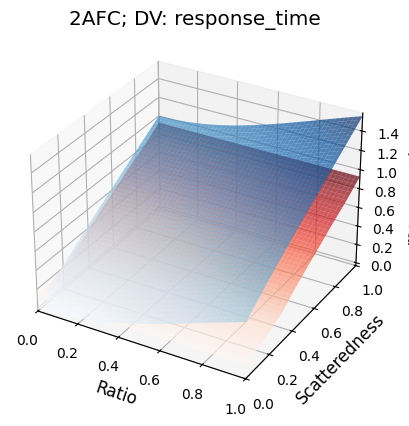

In [38]:
experiment.plotter(s_with_unique_conditions.models[0])

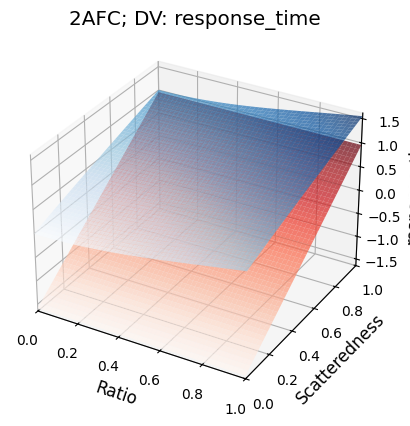

In [40]:
experiment.plotter(s_with_unique_conditions.models[2])

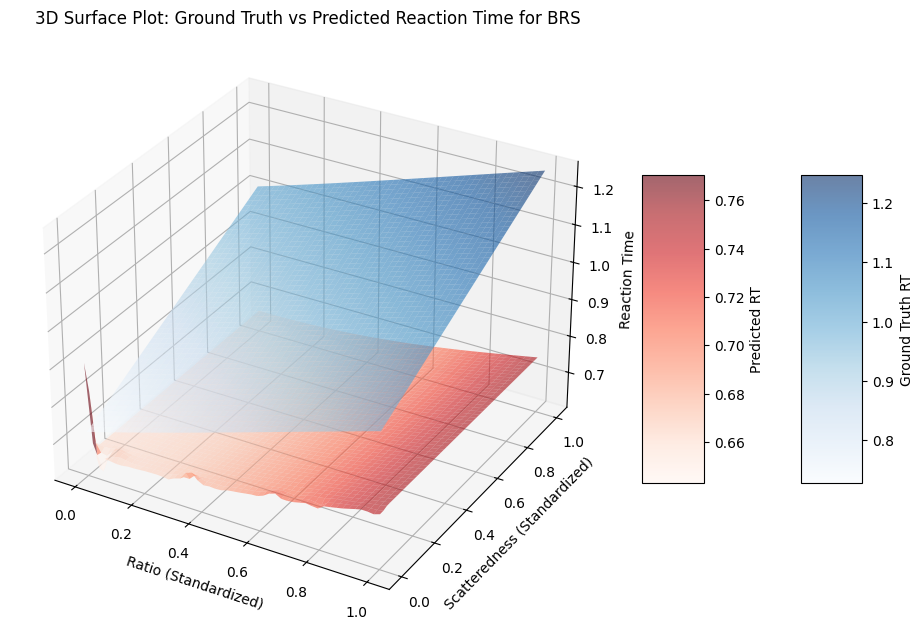

In [50]:
plot_3d_reaction_time(X_unique, y_unique, y_pred_unique, random_data_unique)

We see that the change in experimental design does not significantly alter the overall performance trends of the models.